# EPIC-PN Large Window Mode: double events offset

There is a known difference in the reconstructed energy of events with `PATTERN in [1:4]` (aka double events) and those with `PATTERN == 0` (aka single pixel events). The difference is characterised by an energy offset with time-dependent component, as explained in detail in [XMM-CCF-REL-323](http://xmm2.esac.esa.int/docs/documents/CAL-SRN-0323-1-1.ps.gz).

The double events are corrected for the long-term CTI before they are reconstructed in a single event with a particular pattern. So, for example, an event with energy 8 keV with pattern=1 may initially be listed in the raw event list (PIEVLI) as two events with energies that sum up to 8 keV, e.g. two events of 4 keV. As the long-term CTI is applied on this raw data, then the two events will be corrected with their initial energy. 


In [2]:
import os
import numpy as np
#import altair as alt
import pandas as pd

from astropy.table import Table, Column
from astropy.io import fits
home = os.path.expanduser('~')

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [3]:
def read_cti_ccf(ccf_file,mode_id=2, energy_index=0):
    #
    # utility function to read the EPN CTI calfile and get the dat ain a dictionary
    #
    # mode_id = 0 for PRIME_FULL_WINDOW
    # mode_id = 1 for PRIME_FULL_WINDOW_EXTENDED
    # mode_id = 2 for PRIME_LARGE_WINDOW
    # mode_id = 3 for PRIME_SMALL_WINDOW
    #
    # energy_index = 0 is for Al Ka at 1.486
    # energy_index = 1 is for Mn Ka at 5.8988
    # energy_index = 2 is for Fe Ka at 6.4 keV
    #
    try:
        t = Table.read(f'{ccf_file}',hdu='LONG_TERM_CTI')
        tmp = Table.read(f'{ccf_file}',hdu='LTC_TIMES')
        #times = tmp.data['TIME'][0].flatten()                           
    except:
        print (f"Cannot read CCF file {ccf_file}, it must contain extension with name \"LONG_TERM_CTI\"")
        return None
    times = tmp['TIME'][0]
    tx = t.group_by('MODE_ID')
    mmask = tx.groups.keys['MODE_ID'] == mode_id
    tenergy = tx.groups[mmask].group_by('ENERGY')
    ixxx = np.arange(len(tenergy.groups))
    if (energy_index not in ixxx):
        print (f"The index for the energy {energy_index} is not available for this mode. Only indices: ", ixxx)
        return None
    grp = tenergy.groups[energy_index]
    #print (grp)
    tout = {}
    if (mode_id != 3):
        for iccd in np.arange(1,13):
            xmask = grp['CCD_ID'] == iccd
            tcoeff = grp[xmask]['T_COEFF']
            tout[iccd] = {'mode_id': mode_id, 'ccd': iccd, 'energy': grp['ENERGY'][0],
                'times': times, 'tcoeff': tcoeff[0]}
    else:
        tcoeff = grp['T_COEFF']
        tout[0] = {'mode_id': mode_id, 'ccd': 4, 'energy': grp['ENERGY'][0],
            'times': times, 'tcoeff': tcoeff[0]}
    return tout

In [4]:
def read_evt_offset_ccf(ccf_file,mode_id=2, energy_index=0):
    #
    # utility function to read the EPN cal file and get the data from the COMB_EVT_OFFSET extension in a dictionary
    #
    # mode_id = 0 for PRIME_FULL_WINDOW
    # mode_id = 1 for PRIME_FULL_WINDOW_EXTENDED
    # mode_id = 2 for PRIME_LARGE_WINDOW
    # mode_id = 3 for PRIME_SMALL_WINDOW
    #
    # energy_index = 0 is for Al Ka at 1.486
    # energy_index = 1 is for Mn Ka at 5.8988
    #
    extname = 'COMB_EVT_OFFSET'
    try:
        t = Table.read(f'{ccf_file}',hdu=extname)
    except:
        print (f"Cannot read CCF file {ccf_file}, it must contain extension with name \"{extname}\"")
        return None
    tx = t.group_by('MODE_ID')
    mmask = tx.groups.keys['MODE_ID'] == mode_id
    tenergy = tx.groups[mmask].group_by('ENERGY')
    ixxx = np.arange(len(tenergy.groups))
    if (energy_index not in ixxx):
        print (f"The index for the energy {energy_index} is not available for this mode. Only indices: ", ixxx)
        return None
    grp = tenergy.groups[energy_index]
    #print (grp)
    tout = {}
    if (mode_id != 3):
        for iccd in np.arange(1,13):
            xmask = grp['CCD_ID'] == iccd
            offset = grp[xmask]['SHIFT']
            tout[iccd] = {'mode_id': mode_id, 'ccd': iccd, 'energy': grp['ENERGY'][0],
                'shift': offset}
    else:
        offset = grp['SHIFT']
        tout[0] = {'mode_id': mode_id, 'ccd': 4, 'energy': grp['ENERGY'][0],
            'shift': offset}
    return tout

In [5]:
ccfdir = f"{home}/IVAN/ccfdev"
ccffile = f'{ccfdir}/EPN_CTI_0049.CCF_test51'
#hdu = fits.open(ccffile)
#tshift = read_evt_offset_ccf(ccffile,mode_id=2, energy_index=0)

## Check the offset 

Will plot the offets in the CCF as a function of energy, pattern and CCD


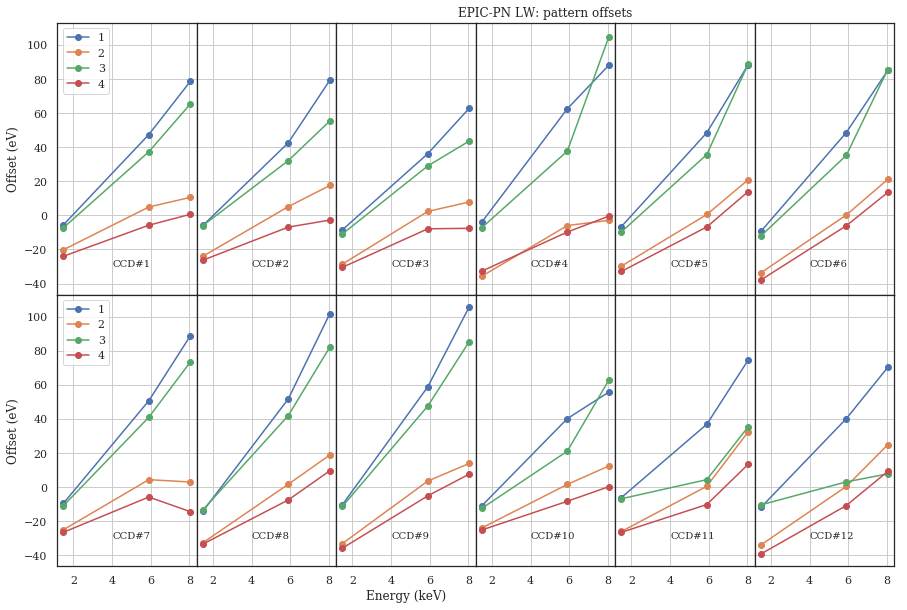

In [6]:
ccfdir = f"{home}/IVAN/ccfdev"
ccffile = f'{ccfdir}/EPN_CTI_0049.CCF_test53'
toff = Table.read(f'{ccffile}',hdu='COMB_EVT_OFFSET')
tx = toff.group_by('MODE_ID')
mmask = tx.groups.keys['MODE_ID'] == 2
toff2 = tx.groups[mmask]
tccd = toff2.group_by('CCD_ID')
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    qmask = (tccd.groups.keys['CCD_ID'] == ccd)
    tq = tccd.groups[qmask]
    for xpat in range(1,5):
        #
        tpat = tq.group_by('PATTERN')
        pmask = tpat.groups.keys['PATTERN'] == xpat
        k = j
        kj = 0
        if (j >= 6):
            k = j - 6
            kj = 1
        axs[kj,k].plot(tpat.groups[pmask]['ENERGY'],tpat.groups[pmask]['SHIFT'],'-o',label=f"{xpat}")
    axs[kj,k].text(4.0,-30.0,f'CCD#{ccd}')
    axs[kj,k].grid()
    if (ccd == 4):
        axs[kj,k].set_title("EPIC-PN LW: pattern offsets")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel(r"Offset (eV)")
        axs[kj,k].legend()
    if (ccd == 9):
        axs[kj,k].set_xlabel("Energy (keV)")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"{ccfdir}/offsets_v53_comparison.png",dpi=100)
plt.show()
plt.close();

In [8]:
#
# read the fit results, suffix can be _myproc (CTI CCF v48), _nocti and _cti49 (testing CCF v49)
#
# CTI49 test51
wdir = f"{home}/IVAN/Cu-line"
t = Table.read(f'{wdir}/fit_results_cuka_cti50.csv')
t51 = Table.read(f'{wdir}/fit_results_cuka_doubles_cti50.csv')
#t51 = Table.read(f'{wdir}/fit_results_cuka_doubles_cti49_test51.csv')
#t52 = Table.read(f'{wdir}/fit_results_cuka_doubles_cti49_test52.csv')
t["deltaE"] = Column((t["lineE"] - 8.04)*1000.0)
t["deltaE_err"] = Column(t["lineE_err"]*1000.0)
tab = t.to_pandas()
#
t51["deltaE"] = Column((t51["lineE"] - 8.04)*1000.0)
t51["deltaE_err"] = Column(t51["lineE_err"]*1000.0)
tab51 = t51.to_pandas()
#t52["deltaE"] = Column((t52["lineE"] - 8.04)*1000.0)
#t52["deltaE_err"] = Column(t52["lineE_err"]*1000.0)
#tab52 = t52.to_pandas()

CCD#1 mean offsets. Singles: 2.9 +/- 14.7, doubles: 0.8 +/- 33.2
CCD#2 mean offsets. Singles: -2.6 +/- 6.0, doubles: -0.6 +/- 11.0
CCD#3 mean offsets. Singles: -2.0 +/- 7.0, doubles: 0.6 +/- 9.0
CCD#4 mean offsets. Singles: 1.8 +/- 27.7, doubles: 5.6 +/- 45.9
CCD#5 mean offsets. Singles: -2.7 +/- 5.5, doubles: -0.8 +/- 11.6
CCD#6 mean offsets. Singles: 0.0 +/- 6.2, doubles: 0.2 +/- 10.5
CCD#7 mean offsets. Singles: 4.4 +/- 12.5, doubles: 8.4 +/- 23.5
CCD#8 mean offsets. Singles: -2.2 +/- 5.3, doubles: -0.9 +/- 8.6
CCD#9 mean offsets. Singles: -0.8 +/- 4.7, doubles: -0.8 +/- 9.9
CCD#10 mean offsets. Singles: -0.3 +/- 10.2, doubles: 0.6 +/- 34.0
CCD#11 mean offsets. Singles: -1.9 +/- 5.0, doubles: -0.9 +/- 11.2
CCD#12 mean offsets. Singles: -0.4 +/- 5.4, doubles: 0.6 +/- 8.3


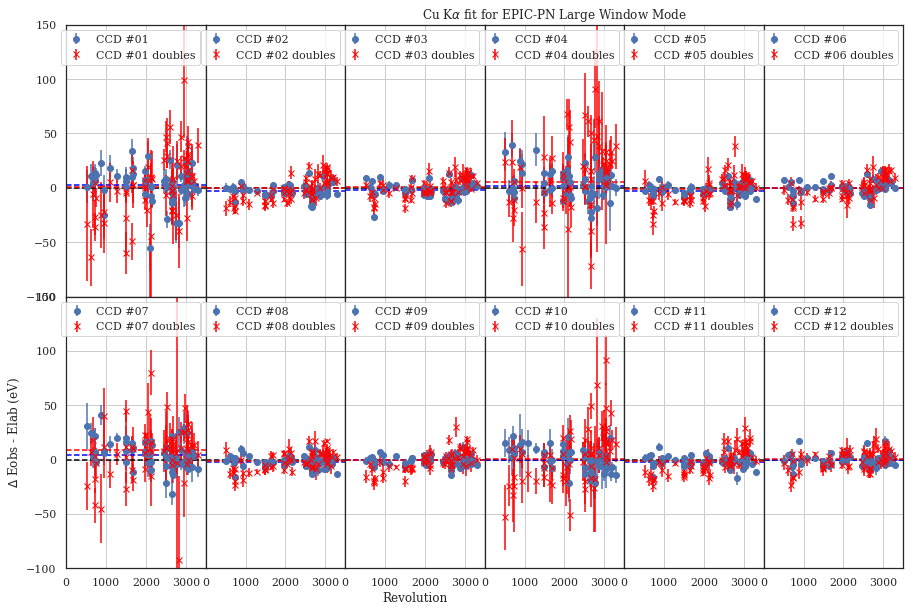

In [13]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
mean1 = {}
mean2 = {}
#mean3 = {}
for j in range(12):
    ccd = j+1
    xtab = tab[tab.ccd == ccd]
    xtab51 = tab51[tab51.ccd == ccd]
    #xtab52 = tab52[tab52.ccd == ccd]
    #
    # now calculate the mean offset for each case: singles or doubles
    #
    mean1[ccd] = np.average(xtab.deltaE)
    mean2[ccd] = np.average(xtab51.deltaE)
    #mean3[ccd] = np.average(xtab52.deltaE)
    st1 = np.std(xtab.deltaE)
    st2 = np.std(xtab51.deltaE)
    #st3 = np.std(xtab52.deltaE)
    print (f"CCD#{ccd} mean offsets. Singles: {mean1[ccd]:.1f} +/- {st1:.1f}," + 
           f" doubles: {mean2[ccd]:.1f} +/- {st2:.1f}")
    #print (f"CCD#{ccd} mean offsets. Singles: {mean1[ccd]:.1f} +/- {st1:.1f}, doubles51: {mean2[ccd]:.1f} +/- {st2:.1f}, doubles52:  {mean3[ccd]:.1f} +/- {st3:.1f}")
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].errorbar(xtab.rev,xtab.deltaE,yerr=(xtab.deltaE_err,xtab.deltaE_err),fmt='o',label=f'CCD #{ccd:02}')
    axs[kj,k].errorbar(xtab51.rev,xtab51.deltaE,yerr=(xtab51.deltaE_err,xtab51.deltaE_err),fmt='x',color='red',label=f'CCD #{ccd:02} doubles')
    #axs[kj,k].errorbar(xtab52.rev,xtab52.deltaE,yerr=(xtab52.deltaE_err,xtab52.deltaE_err),fmt='^',color='cyan',label=f'CCD #{ccd:02} doubles52')
    axs[kj,k].axhline(0.0,color='black',ls='dashed')
    #
    axs[kj,k].axhline(mean1[ccd],color='blue',ls='dashed')
    axs[kj,k].axhline(mean2[ccd],color='red',ls='dashed')
    #axs[kj,k].axhline(mean3[ccd],color='cyan',ls='dashed')
    #
    axs[kj,k].set_xlim((0,3500))
    axs[kj,k].set_ylim((-100.0,150.0))
    axs[kj,k].grid(True)
    axs[kj,k].legend()
    if (ccd == 4):
        axs[kj,k].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 7):
        axs[kj,k].set_ylabel(r"$\Delta$ Eobs - Elab (eV)")
    if (ccd == 9):
        axs[kj,k].set_xlabel("Revolution")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
plt.savefig(f"{wdir}/cuka_results_singles_and_doubles_cti50_plot.png",dpi=100)
#plt.savefig(f"{wdir}/../cuka_results_all_cti49_test51_plot.png",dpi=100)
#plt.savefig(f"{wdir}/../cuka_results_allccd_myproc_plot.png",dpi=100)
plt.show();
plt.close();


Preparing the CCF file with the offsets. I need ot add a new energy 8.04 keV for each CCD and at each of the patterns from 0 to 4. This means 12 x 5 = 60 new lines. At the moment the shifts for pattern in 1 to 4 are the same.


In [87]:
import time
today = time.strftime("%c")
#
extname = 'COMB_EVT_OFFSET'
#
ccf49_file = f"{wdir}/../ccfdev/EPN_CTI_0049.CCF_test51"
hdu49 = fits.open(f"{ccf49_file}")
ltc49 = hdu49[extname]
# only PN Large Window mode
ix49 = np.where(ltc49.data['MODE_ID'] == 2)[0]
nrows = ltc49.data.shape[0]
xhdu = fits.BinTableHDU.from_columns(ltc49.columns, nrows=nrows+12*5,name=extname,header=ltc49.header)
#xhdu = fits.BinTableHDU.from_columns(ltc49.columns,name=extname,header=ltc49.header)
npat = 5 # number of patterns
for ccd in np.arange(1,13):
    for patt in np.arange(5):
        k = nrows + (ccd-1)*npat + patt
        xhdu.data['MODE_ID'][k] = 2
        xhdu.data['CCD_ID'][k] = ccd
        xhdu.data['PATTERN'][k] = patt
        xhdu.data['ENERGY'][k] = 8.04
        if (patt == 0):
            xhdu.data['SHIFT'][k] = 0.0
        else:
            xhdu.data['SHIFT'][k] = f"{mean2[ccd]:.1f}"
#
idx_sorted = np.lexsort((xhdu.data['ENERGY'],xhdu.data['PATTERN'],xhdu.data['CCD_ID'],xhdu.data['MODE_ID']))
xhdu.data = xhdu.data[idx_sorted]
#xhdu.header.remove('HISTORY',remove_all=True)
xhdu.header.add_history(f'Created by Ivan V, {today}')
hdu49[extname] = xhdu
hdu49[0].header['FILENAME'] = "EPN_CTI_0049.CCF"
hdu49.writeto(f"{wdir}/../ccfdev/EPN_CTI_0049.CCF_test52",overwrite=True)
hdu49.close()

In [88]:
df = pd.DataFrame(hdu49[extname].data)

In [89]:
df[df.MODE_ID == 2]

,MODE_ID,CCD_ID,PATTERN,ENERGY,SHIFT
240,2,1,0,1.4860,0.000000
241,2,1,0,5.8988,0.000000
242,2,1,0,8.0400,0.000000
243,2,1,1,1.4860,-5.600000
244,2,1,1,5.8988,47.400002
245,2,1,1,8.0400,27.100000
246,2,1,2,1.4860,-20.200001
247,2,1,2,5.8988,4.900000
248,2,1,2,8.0400,27.100000
249,2,1,3,1.4860,-7.300000
